## Description

* Use the data of properties sold in 2019 and aggregate gun violence data from incidents occurred 1 mile from every prperty. 
* Assigns a gun violence score to each property using the formula $score = \frac{n_{incidents} \;+\; 1.5 \; \times \; n_{injured} \;+\;2.0 \; \times \; n_{killed}}{n_{years}}$ where: 
    * $n_{incidents}$ = Total number of incidents reported within 1 mile of the property between the years 2013 and 2015
    * $n_{injured}$ = Total number of people that were injured in those incidents
    * $n_{killed}$ = Total number of people that were killed in those incidents 
    * $n_{years}$ = The number of years for which the data shows reports of gun violence incidents. For the dataset used $n_{years} = 5$
* Data was divided in tiers according to sale price and correlation with gun violence score analyzed.
    * Tier 1 -> 100,000 - 250,000
    * Tier 2 -> 250,000 - 400,000
    * Tier 3 -> 400,000 + 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd

from arcgis.gis import GIS
gis = GIS()

In [2]:
# path to file with the total of incidents, injured and killed within 1 mile of each property
gun_violence_path = '../Data/arcgis/property_point_view_2019_gun_viol_totals_1.0_miles.csv'

# path to dataset of properties sold in 2019
prop_path = '../Data/arcgis/property_point_view_2019.csv'

# path to dataset of shape files of zip codes in south florida. 
map_path = '../Data/maps/south_fl_zips'

## Helper Functions

In [3]:
def corr(df):
    corr = df.corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
    plt.show()
#     return corr

def slice_by_price(df, min_p=100000, max_p=350000):
    df = df[(df.PRICE_1 >= min_p) & 
            (df.PRICE_1 <= max_p)].reset_index()
    return df

def heatmap(variable, map_df, title='', cmap='Blues', figsize=(10,6)):
    """ 
    Display a heatmap for the provided virable.
  
    Parameters: 
    variable (str): The name of the variable (column) in the map dataframe for which you want to display the heatmap.
    map_df (geopandas data frame): Map dataframe created using geopandas. 
    title (str): Optional title for the chart.
    cmap (str): Color for the heatmap
    figsize ((int,int)): Size of the figure.
    """
    
    # chloropleth range
    vmin, vmax = min(map_df[variable]), max(map_df[variable])
    
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=figsize)
    
    # create map
    map_df.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8')
    
    # remove the axis
    ax.axis('off')

    # add a title
    ax.set_title(title, \
                  fontdict={'fontsize': '25',
                            'fontweight' : '3'})


    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, orientation='horizontal', pad = 0, shrink = 0.40)
    
def six_sigma_filter(df, column):
    sigma = df[column].std()
    mu = df[column].mean()
    three_sigma = [mu-(3*sigma), mu+(3*sigma)]
    print("Column:{}, Mean:{}, Sigma:{}, 6 sigma_range: {}:{}".format(column,mu.round(3),
                                                                       sigma.round(3),
                                                                       three_sigma[0].round(2),
                                                                       three_sigma[1].round(2)))
    
    # filter
    df_to_keep = df[(df[column] > three_sigma[0]) & (df[column] < three_sigma[1])]
    
    # prints
    num_rows_dropped = df.shape[0] - df_to_keep.shape[0]
    print("Number of rows dropped: " + str(num_rows_dropped))
    
    return df_to_keep



def iqr_filter(df, column):
    med = df[column].median()
    p_25 = df[column].quantile(q=0.25)
    p_75 = df[column].quantile(q=0.75)
    
    # find valid range
    iqr_range = [med-(2*p_25), med+(2*p_75)]
    print("Column: {}, Median:{}, 25%:{}, 75%:{}, IQR:{}:{}".format(column,med,
                                                                    p_25,p_75,
                                                                    iqr_range[0].round(2),
                                                                    iqr_range[1].round(2)))
    
    # filter
    df_to_keep = df[(df[column] > iqr_range[0]) & (df[column] < iqr_range[1])]
    
    #prints
    num_rows_dropped = df.shape[0] - df_to_keep.shape[0]
    print("Number of rows dropped: " + str(num_rows_dropped))
    
    return df_to_keep


def draw(df, col, map_widget, cmap='OrRd', class_count=10):
    df.spatial.plot(map_widget=map_widget,
                class_count=class_count,
                renderer_type='c',
                method='esriClassifyNaturalBreaks',
                col=col,
                cmap=cmap,
                alpha=0.8,
                outline_color=[0,0,0,0])
    
    
def scale(df, col, quantiles):
    score = 0
    df = df.copy()
    for idx, q in enumerate(quantiles):
        score =+1
        q_val_min = df[col].quantile(quantiles[idx - 1]) if idx > 0 else 0
        q_val_max = df[col].quantile(q)
        df.loc[(df[col] >= q_val_min) & (df[col] < q_val_max), col] = score

    max_q = df[col].quantile(quantiles[len(quantiles) - 1]) 
    df.loc[df[col] >= max_q, col] = score + 1
    return df

def min_max_scale(df, cols):
    mm_scaler = MinMaxScaler() 
    scaled_array = mm_scaler.fit_transform(df[cols])
    return pd.DataFrame(scaled_array, columns=cols)

def quantile(df, col, q):
    q_val = df[col].quantile(q)
    return df[df[col] >= q_val].reset_index(drop=True)

def less_than_quantile(df, col, q):
    q_val = df[col].quantile(q)
    return df[df[col] <= q_val].reset_index(drop=True)

def between_quantiles(df, col, q_min=0.0, q_max=1.0):
    q_val_min = df[col].quantile(q_min)
    q_val_max = df[col].quantile(q_max)
    return df[(df[col] <= q_val_max) & (df[col] >= q_val_min) ].reset_index(drop=True)

## Analysis

In [4]:
gun_violence_df = pd.read_csv(gun_violence_path)
prop_df = pd.read_csv(prop_path)

In [5]:
gun_violence_df = gun_violence_df.drop('property_index', axis=1)
print(gun_violence_df.shape)
gun_violence_df.head()

(16399, 3)


incident_count  injured_count  killed_count
0              72             71            27
1              64             67            24
2              65             68            24
3              68             67            27
4              68             69            26

In [6]:
# replace condo flag: N--> 0 , Y --> 1

prop_df.replace({'CONDO_FLAG' : {'Y': 1, 'N':0}}, inplace=True)

print(prop_df.shape)
prop_df.head()

(16399, 19)


X          Y         CITY      ZIP  CONDO_FLAG  BEDROOM_COUNT  \
0 -80.201382  25.843438  NORTH MIAMI  33150.0           0            2.0   
1 -80.204222  25.845806        MIAMI  33150.0           0            3.0   
2 -80.203909  25.845515        MIAMI  33150.0           0            2.0   
3 -80.206837  25.846260        MIAMI  33150.0           0            4.0   
4 -80.201535  25.844182  MIAMI BEACH  33150.0           0            2.0   

   BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT  UNIT_COUNT  \
0             1.0                  0.0          1.0         1.0   
1             1.0                  0.0          1.0         1.0   
2             1.0                  0.0          1.0         1.0   
3             4.0                  0.0          1.0         2.0   
4             2.0                  0.0          1.0         1.0   

   BUILDING_ACTUAL_AREA  BUILDING_HEATED_AREA  LOT_SIZE  YEAR_BUILT  \
0                1237.0                1237.0    7875.0      1924.0   
1                1693.0                1693.0    7390.5      1936.0   
2                1020.0                 728.0    4450.0      1936.0   
3                1918.0                1750.0    5294.0      1998.0   
4                1517.0                1517.0   20100.0      1925.0   

   ASSESSMENT_YEAR_CUR  ASSESSED_VAL_CUR   PRICE_1             DATEOFSALE_UTC  \
0               2020.0          166702.0  168000.0  2019-07-08 04:00:00+00:00   
1               2020.0          169942.0  159000.0  2019-07-17 04:00:00+00:00   
2               2020.0           70838.0  129900.0  2019-01-31 05:00:00+00:00   
3               2020.0          155062.0  240000.0  2019-03-12 04:00:00+00:00   
4               2020.0          188046.0  335000.0  2019-06-03 04:00:00+00:00   

   SQRD_FOOT_PRICE  
0       135.812449  
1        93.916125  
2       127.352941  
3       125.130344  
4       220.830587

Column:SQRD_FOOT_PRICE, Mean:197.918, Sigma:92.287, 6 sigma_range: -78.94:474.78
Number of rows dropped: 280


(array([ 664., 2878., 4547., 3703., 1907.,  988.,  686.,  387.,  209.,
         150.]), array([ 50.        ,  92.45529574, 134.91059147, 177.36588721,
        219.82118294, 262.27647868, 304.73177442, 347.18707015,
        389.64236589, 432.09766162, 474.55295736]), <a list of 10 Patch objects>)

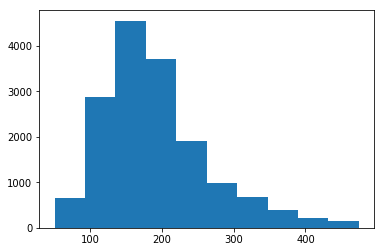

In [7]:
#  apply 6 sigma filter to remove outliers

prop_df = six_sigma_filter(prop_df, 'SQRD_FOOT_PRICE')
plt.hist(prop_df['SQRD_FOOT_PRICE'])

## Merged data

In [8]:
prop_gun_violence_df = prop_df.merge(gun_violence_df, left_index=True, right_index=True) 
prop_gun_violence_df = pd.DataFrame.spatial.from_xy(prop_gun_violence_df, 'X' , 'Y')
prop_gun_violence_df.head()

X          Y         CITY      ZIP  CONDO_FLAG  BEDROOM_COUNT  \
0 -80.201382  25.843438  NORTH MIAMI  33150.0           0            2.0   
1 -80.204222  25.845806        MIAMI  33150.0           0            3.0   
2 -80.203909  25.845515        MIAMI  33150.0           0            2.0   
3 -80.206837  25.846260        MIAMI  33150.0           0            4.0   
4 -80.201535  25.844182  MIAMI BEACH  33150.0           0            2.0   

   BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT  UNIT_COUNT  ...  \
0             1.0                  0.0          1.0         1.0  ...   
1             1.0                  0.0          1.0         1.0  ...   
2             1.0                  0.0          1.0         1.0  ...   
3             4.0                  0.0          1.0         2.0  ...   
4             2.0                  0.0          1.0         1.0  ...   

   YEAR_BUILT  ASSESSMENT_YEAR_CUR  ASSESSED_VAL_CUR   PRICE_1  \
0      1924.0               2020.0          166702.0  168000.0   
1      1936.0               2020.0          169942.0  159000.0   
2      1936.0               2020.0           70838.0  129900.0   
3      1998.0               2020.0          155062.0  240000.0   
4      1925.0               2020.0          188046.0  335000.0   

              DATEOFSALE_UTC  SQRD_FOOT_PRICE  incident_count injured_count  \
0  2019-07-08 04:00:00+00:00       135.812449              72            71   
1  2019-07-17 04:00:00+00:00        93.916125              64            67   
2  2019-01-31 05:00:00+00:00       127.352941              65            68   
3  2019-03-12 04:00:00+00:00       125.130344              68            67   
4  2019-06-03 04:00:00+00:00       220.830587              68            69   

   killed_count                                              SHAPE  
0            27  {'x': -80.20138240732476, 'y': 25.843437835928...  
1            24  {'x': -80.20422221280491, 'y': 25.845805691155...  
2            24  {'x': -80.20390876455104, 'y': 25.845515264645...  
3            27  {'x': -80.20683722656327, 'y': 25.846260045702...  
4            26  {'x': -80.20153452713662, 'y': 25.844182077073...  

[5 rows x 23 columns]

In [9]:
prop_gun_violence_df.describe()

X             Y           ZIP    CONDO_FLAG  BEDROOM_COUNT  \
count  16119.000000  16119.000000  16119.000000  16119.000000   16119.000000   
mean     -80.302988     25.758436  33128.753521      0.339475       2.710466   
std        0.102524      0.142194     60.360614      0.473546       1.077346   
min      -80.557561     25.399216  33010.000000      0.000000       0.000000   
25%      -80.387399     25.668412  33125.000000      0.000000       2.000000   
50%      -80.316033     25.770776  33150.000000      0.000000       3.000000   
75%      -80.212259     25.877218  33176.000000      1.000000       3.000000   
max      -80.119450     25.974065  33196.000000      1.000000       9.000000   

       BATHROOM_COUNT  HALF_BATHROOM_COUNT   FLOOR_COUNT    UNIT_COUNT  \
count    16119.000000         16119.000000  16119.000000  16119.000000   
mean         1.842670             0.142254      0.829208      1.034121   
std          0.683188             0.352680      0.705957      0.181546   
min          0.000000             0.000000      0.000000      1.000000   
25%          1.000000             0.000000      0.000000      1.000000   
50%          2.000000             0.000000      1.000000      1.000000   
75%          2.000000             0.000000      1.000000      1.000000   
max          6.000000             2.000000     11.000000      2.000000   

       BUILDING_ACTUAL_AREA  BUILDING_HEATED_AREA       LOT_SIZE  \
count          16119.000000          16119.000000   16119.000000   
mean            1663.514424           1483.723928    5086.628887   
std              734.396260            584.975386    8449.356688   
min              500.000000            480.000000       0.000000   
25%             1107.500000           1060.000000       0.000000   
50%             1533.000000           1394.000000    4864.000000   
75%             2077.000000           1794.000000    7546.000000   
max             5923.000000           5046.000000  217800.000000   

         YEAR_BUILT  ASSESSMENT_YEAR_CUR  ASSESSED_VAL_CUR        PRICE_1  \
count  16119.000000              16119.0      1.611900e+04   16119.000000   
mean    1979.048638               2020.0      2.076478e+05  291827.658540   
std       22.173368                  0.0      1.067746e+05  113805.711903   
min     1901.000000               2020.0      1.272200e+04  100000.000000   
25%     1960.000000               2020.0      1.307080e+05  200000.000000   
50%     1978.000000               2020.0      1.925760e+05  280000.000000   
75%     2000.000000               2020.0      2.640895e+05  365000.000000   
max     2019.000000               2020.0      3.182000e+06  600000.000000   

       SQRD_FOOT_PRICE  incident_count  injured_count  killed_count  
count     16119.000000    16119.000000   16119.000000  16119.000000  
mean        190.933809       11.444817       8.148148      4.394131  
std          74.279587       16.221270      14.535784      6.613162  
min          50.000000        0.000000       0.000000      0.000000  
25%         140.073224        2.000000       1.000000      1.000000  
50%         177.025964        5.000000       3.000000      2.000000  
75%         224.833852       14.000000       9.000000      5.000000  
max         474.552957      113.000000     143.000000     55.000000

## Find Score

Use formula $score = \frac{n_{incidents} \;+\; 1.5 \; \times \; n_{injured} \;+\;2.0 \; \times \; n_{killed}}{n_{years}}$ to assign a gun violence score to each property

In [10]:
incidents_weight = 1.0
injured_weight = 1.5
killed_weight = 2.0
n_years = 5


prop_gun_violence_df['gun_viol_score'] = (killed_weight*prop_gun_violence_df['killed_count'] 
+ injured_weight*prop_gun_violence_df['injured_count'] +  incidents_weight*prop_gun_violence_df['incident_count'])/n_years



In [11]:
prop_gun_violence_df.describe()

X             Y           ZIP    CONDO_FLAG  BEDROOM_COUNT  \
count  16119.000000  16119.000000  16119.000000  16119.000000   16119.000000   
mean     -80.302988     25.758436  33128.753521      0.339475       2.710466   
std        0.102524      0.142194     60.360614      0.473546       1.077346   
min      -80.557561     25.399216  33010.000000      0.000000       0.000000   
25%      -80.387399     25.668412  33125.000000      0.000000       2.000000   
50%      -80.316033     25.770776  33150.000000      0.000000       3.000000   
75%      -80.212259     25.877218  33176.000000      1.000000       3.000000   
max      -80.119450     25.974065  33196.000000      1.000000       9.000000   

       BATHROOM_COUNT  HALF_BATHROOM_COUNT   FLOOR_COUNT    UNIT_COUNT  \
count    16119.000000         16119.000000  16119.000000  16119.000000   
mean         1.842670             0.142254      0.829208      1.034121   
std          0.683188             0.352680      0.705957      0.181546   
min          0.000000             0.000000      0.000000      1.000000   
25%          1.000000             0.000000      0.000000      1.000000   
50%          2.000000             0.000000      1.000000      1.000000   
75%          2.000000             0.000000      1.000000      1.000000   
max          6.000000             2.000000     11.000000      2.000000   

       BUILDING_ACTUAL_AREA  ...       LOT_SIZE    YEAR_BUILT  \
count          16119.000000  ...   16119.000000  16119.000000   
mean            1663.514424  ...    5086.628887   1979.048638   
std              734.396260  ...    8449.356688     22.173368   
min              500.000000  ...       0.000000   1901.000000   
25%             1107.500000  ...       0.000000   1960.000000   
50%             1533.000000  ...    4864.000000   1978.000000   
75%             2077.000000  ...    7546.000000   2000.000000   
max             5923.000000  ...  217800.000000   2019.000000   

       ASSESSMENT_YEAR_CUR  ASSESSED_VAL_CUR        PRICE_1  SQRD_FOOT_PRICE  \
count              16119.0      1.611900e+04   16119.000000     16119.000000   
mean                2020.0      2.076478e+05  291827.658540       190.933809   
std                    0.0      1.067746e+05  113805.711903        74.279587   
min                 2020.0      1.272200e+04  100000.000000        50.000000   
25%                 2020.0      1.307080e+05  200000.000000       140.073224   
50%                 2020.0      1.925760e+05  280000.000000       177.025964   
75%                 2020.0      2.640895e+05  365000.000000       224.833852   
max                 2020.0      3.182000e+06  600000.000000       474.552957   

       incident_count  injured_count  killed_count  gun_viol_score  
count    16119.000000   16119.000000  16119.000000    16119.000000  
mean        11.444817       8.148148      4.394131        6.491060  
std         16.221270      14.535784      6.613162       10.000444  
min          0.000000       0.000000      0.000000        0.000000  
25%          2.000000       1.000000      1.000000        1.100000  
50%          5.000000       3.000000      2.000000        2.900000  
75%         14.000000       9.000000      5.000000        7.300000  
max        113.000000     143.000000     55.000000       85.100000  

[8 rows x 21 columns]

## Correlations

In [12]:
corr_cols = ['SQRD_FOOT_PRICE', 'gun_viol_score', 'CONDO_FLAG']

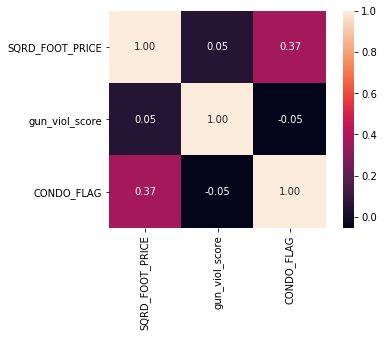

In [13]:
corr(prop_gun_violence_df[corr_cols])

## Split by price

In [14]:
tier_1 = slice_by_price(prop_gun_violence_df, min_p=100_000, max_p=250_000)
tier_2 = slice_by_price(prop_gun_violence_df, min_p=250_000, max_p=400_000)
tier_3 = slice_by_price(prop_gun_violence_df, min_p=400_000, max_p=float("inf"))

       SQRD_FOOT_PRICE  gun_viol_score   CONDO_FLAG
count      6504.000000     6504.000000  6504.000000
mean        166.179717        8.608472     0.547970
std          63.582737       12.763357     0.497732
min          50.000000        0.000000     0.000000
25%         120.518852        1.500000     0.000000
50%         156.964931        3.900000     1.000000
75%         199.074074        9.500000     1.000000
max         456.349206       85.100000     1.000000


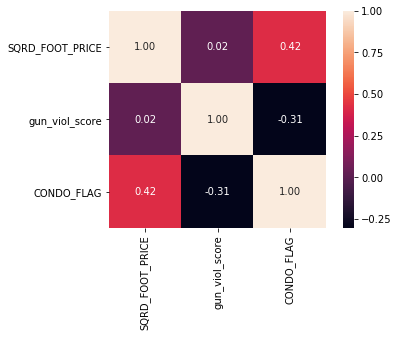

In [15]:
print(tier_1[corr_cols].describe())
corr(tier_1[corr_cols])

       SQRD_FOOT_PRICE  gun_viol_score   CONDO_FLAG
count      7232.000000     7232.000000  7232.000000
mean        200.023208        5.602779     0.206029
std          71.406956        7.821630     0.404479
min          57.487127        0.000000     0.000000
25%         151.109952        1.100000     0.000000
50%         184.692783        2.700000     0.000000
75%         233.039037        6.900000     0.000000
max         474.552957       81.300000     1.000000


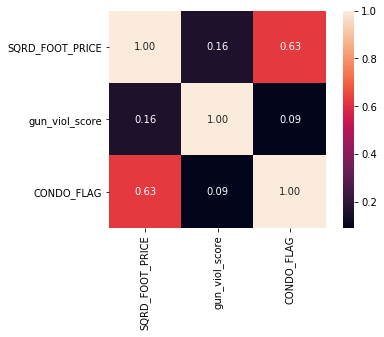

In [16]:
print(tier_2[corr_cols].describe())
corr(tier_2[corr_cols])

       SQRD_FOOT_PRICE  gun_viol_score   CONDO_FLAG
count      2810.000000     2810.000000  2810.000000
mean        227.206809        3.874199     0.192171
std          84.460956        5.620521     0.394077
min          73.406160        0.000000     0.000000
25%         162.604965        0.500000     0.000000
50%         204.695117        1.600000     0.000000
75%         277.416262        4.900000     0.000000
max         473.118280       66.000000     1.000000


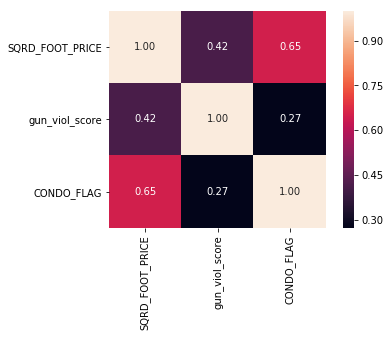

In [17]:
print(tier_3[corr_cols].describe())
corr(tier_3[corr_cols])

In [18]:
tier_1.columns
corr_columns_scaled = ['BEDROOM_COUNT', 'BATHROOM_COUNT', 'BUILDING_ACTUAL_AREA', 
                       'YEAR_BUILT', 'PRICE_1', 'SQRD_FOOT_PRICE', 'incident_count',
                      'injured_count', 'killed_count', 'gun_viol_score']

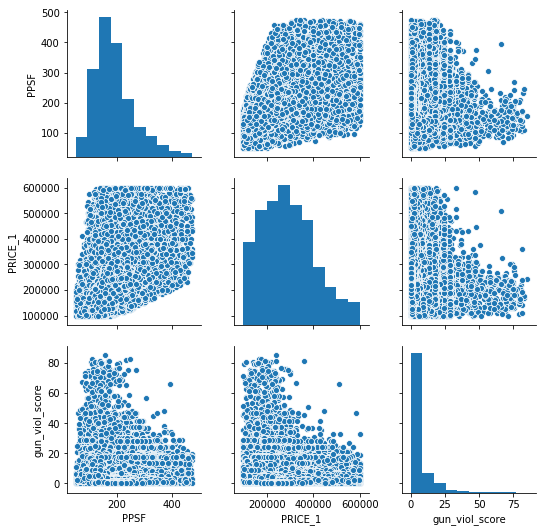

In [19]:
renamed = prop_gun_violence_df.rename(columns={'SQRD_FOOT_PRICE':'PPSF'})
grd_2= sns.pairplot(data=renamed[['PPSF', 'PRICE_1', 'gun_viol_score']])
grd_2.savefig('gun_violence.png')

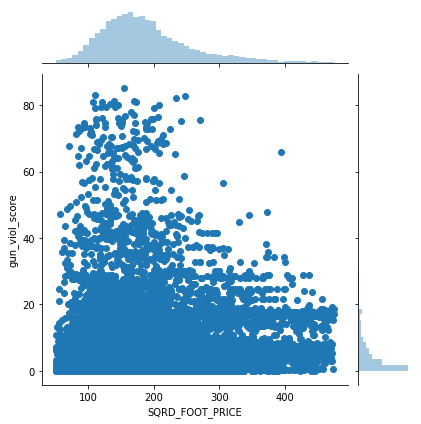

In [20]:
sns.jointplot('SQRD_FOOT_PRICE', 'gun_viol_score', data=prop_gun_violence_df)

9


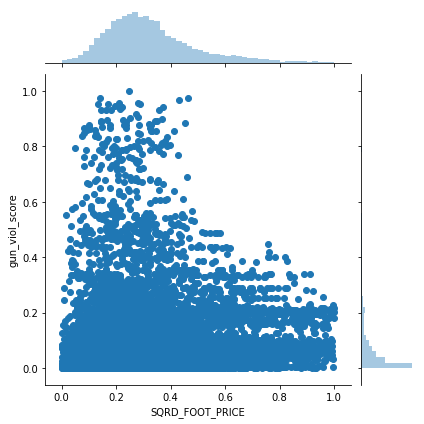

In [21]:
ppsf_gv = min_max_scale(prop_gun_violence_df, 
                        ['gun_viol_score', 'SQRD_FOOT_PRICE'])

# df.loc[df['line_race']==0].index
to_drop = ppsf_gv.loc[(ppsf_gv['SQRD_FOOT_PRICE'] >=0.5) & (ppsf_gv['gun_viol_score'] >=0.5)].index
print(len(to_drop))
ppsf_gv = ppsf_gv.drop(to_drop)
sns.jointplot('SQRD_FOOT_PRICE', 'gun_viol_score', data=ppsf_gv)


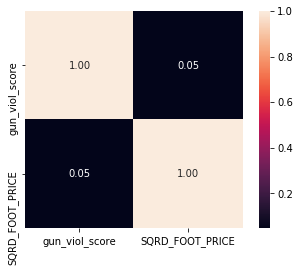

In [22]:
corr(ppsf_gv)

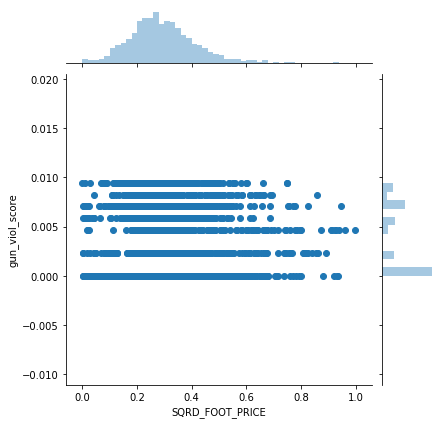

In [23]:
top_60p = between_quantiles(ppsf_gv, 'gun_viol_score', q_max=0.2)
sns.jointplot('SQRD_FOOT_PRICE', 'gun_viol_score', data=top_60p)

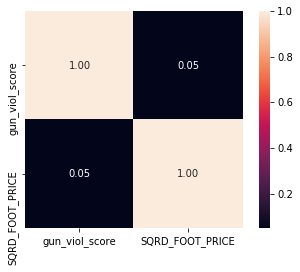

In [24]:
corr(top_60p)

In [25]:
# grd_2 = sns.pairplot(data=tier_2[corr_cols])

In [26]:
# grd_3 = sns.pairplot(data=tier_3[corr_cols])

In [27]:
# by_zip_df = prop_gun_violence_df.groupby('ZIP').mean()
# by_zip_df.describe()

In [28]:
# by_zip_df.sort_values(by=['gun_viol_score'])

In [29]:
# by_zip_df.sort_values(by=['PRICE_1'])

In [30]:
# prop_gun_violence_df['ZIP'] = prop_gun_violence_df['ZIP'].apply(lambda x: str(x))
# prop_gun_violence_df['ZIP'].hist(bins=100, xrot=90, figsize=(17,5))

In [31]:
violence_score_map = gis.map('Miami, FL')
violence_score_map.basemap='gray'
violence_score_map

MapView(layout=Layout(height='400px', width='100%'))

In [32]:
draw(quantile(prop_gun_violence_df, 'gun_viol_score', 0.5), 
     col='gun_viol_score', 
     map_widget=violence_score_map, 
     cmap='OrRd', 
     class_count=12)

In [33]:
mean_by_zip = prop_gun_violence_df.groupby('ZIP').mean()
mean_by_zip = mean_by_zip.sort_values(by='gun_viol_score', ascending=False)

## Visualize gun violence impact on price per square feet

### Mean gun violence score versus mean price per square feet by zip


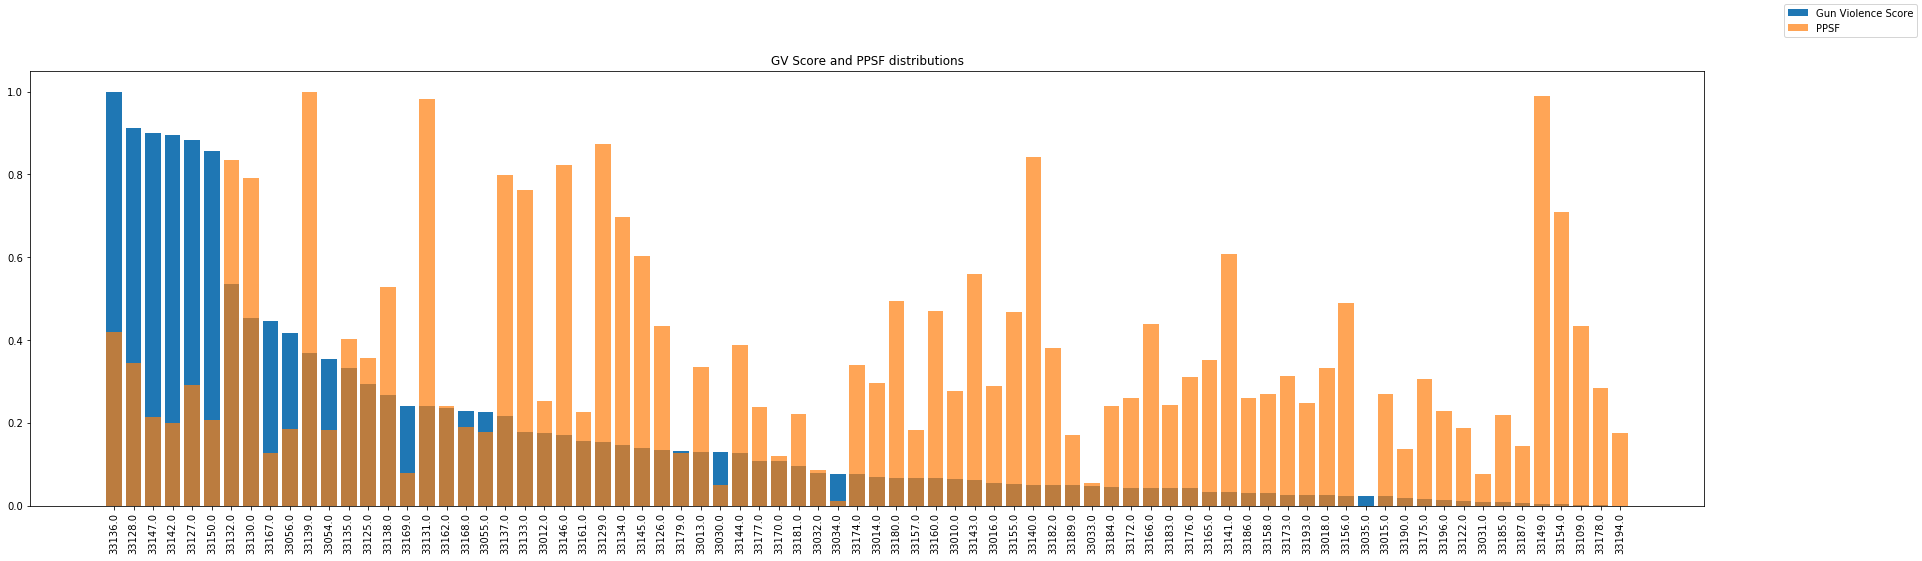

In [34]:
# Mean gun violence score versus mean price per square feet by zip

import numpy as np


by_zip_scaled = min_max_scale(mean_by_zip, ['gun_viol_score', 'SQRD_FOOT_PRICE'])
mean_by_zip['gun_viol_score'] = by_zip_scaled['gun_viol_score'].values
mean_by_zip['SQRD_FOOT_PRICE'] = by_zip_scaled['SQRD_FOOT_PRICE'].values

zips = mean_by_zip.index
gv_scores = mean_by_zip.gun_viol_score.values
ppsf_distr = mean_by_zip.SQRD_FOOT_PRICE.values

y_pos = np.arange(len(zips))

fig, ax = plt.subplots(figsize=(30,8))

plt.bar(y_pos, gv_scores, align='center', label='Gun Violence Score')
plt.bar(y_pos, ppsf_distr, align='center', alpha=0.7, label='PPSF')

plt.xticks(y_pos, zips, rotation='vertical')
# plt.ylabel('Number of Incidents')
plt.title('GV Score and PPSF distributions')

fig.legend()
fig.show()
plt.savefig('gv_score_mean_price')

### Properties with highest gun violence score and highest prices per square foot

Highest gun violence scores are depicted in scales of red while highest prices per square feet are in scale of green.
The darker the color, the larger the value.

In [37]:
sqrd_foot_price_map = gis.map('Miami, FL')
sqrd_foot_price_map.basemap='gray'
sqrd_foot_price_map

MapView(layout=Layout(height='400px', width='100%'))

In [38]:
top_quantile = prop_gun_violence_df.SQRD_FOOT_PRICE.quantile(0.90)
top_crime = prop_gun_violence_df.gun_viol_score.quantile(0.90)

print(top_quantile)
print(top_crime)


draw(prop_gun_violence_df[prop_gun_violence_df['SQRD_FOOT_PRICE'] >= top_quantile].reset_index(), 
     col='SQRD_FOOT_PRICE',
     map_widget=sqrd_foot_price_map, 
     cmap='YlGn')

draw(prop_gun_violence_df[prop_gun_violence_df['gun_viol_score'] >= top_crime].reset_index(), 
     col='gun_viol_score',
     map_widget=sqrd_foot_price_map)



295.2202769508099
17.1


In [41]:
prop_gun_violence_df.columns

Index(['X', 'Y', 'CITY', 'ZIP', 'CONDO_FLAG', 'BEDROOM_COUNT',
       'BATHROOM_COUNT', 'HALF_BATHROOM_COUNT', 'FLOOR_COUNT', 'UNIT_COUNT',
       'BUILDING_ACTUAL_AREA', 'BUILDING_HEATED_AREA', 'LOT_SIZE',
       'YEAR_BUILT', 'ASSESSMENT_YEAR_CUR', 'ASSESSED_VAL_CUR', 'PRICE_1',
       'DATEOFSALE_UTC', 'SQRD_FOOT_PRICE', 'incident_count', 'injured_count',
       'killed_count', 'SHAPE', 'gun_viol_score'],
      dtype='object')

In [42]:
cols_to_scale = ['BEDROOM_COUNT', 'BATHROOM_COUNT', 'SQRD_FOOT_PRICE', 'PRICE_1', 'gun_viol_score']
scaled = min_max_scale(prop_gun_violence_df, cols_to_scale)
scaled.head()

BEDROOM_COUNT  BATHROOM_COUNT  SQRD_FOOT_PRICE  PRICE_1  gun_viol_score
0       0.222222        0.166667         0.202124   0.1360        0.546416
1       0.333333        0.166667         0.103441   0.1180        0.499412
2       0.222222        0.166667         0.182199   0.0598        0.505288
3       0.444444        0.666667         0.176963   0.2800        0.522914
4       0.222222        0.333333         0.402378   0.4700        0.525264

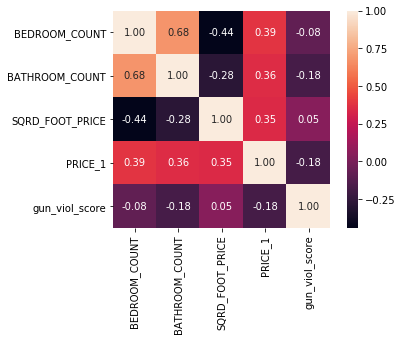

In [43]:
corr(scaled)

(1635, 5)


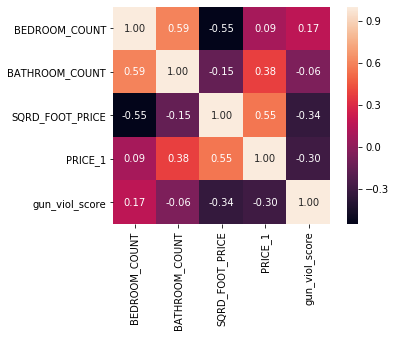

In [44]:
quantile_df = quantile(scaled, 'gun_viol_score', 0.9)
print(quantile_df.shape)
corr(quantile_df)

(16119, 5)


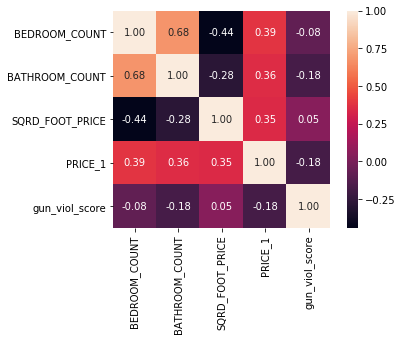

In [45]:
quantile_df_1 = between_quantiles(scaled, 'gun_viol_score', q_min=0.0, q_max=1.0)
print(quantile_df_1.shape)
corr(quantile_df_1)